

# Kalshi Presidential Betting and Sentiment Analysis
## Spring 2025 Data Science Project
### Names: Hemang Vasu, Ethan Qiu, Violet Zheng, Jake Liu



#Introduction

Kalshi is a U.S. goverment-regulated prediction market platform that allows individuals to trade on the outcomes of real-world events. Traders can buy and sell binary contracts that resolve to either $1$ (if the event occurs) or $0$ (if it doesn't), making Kalshi function like a financial exchange based on societal, political, or economic uncertainty. What sets Kalshi apart from informal prediction platforms is its oversight by the Commodity Futures Trading Commission (CFTC), giving it legal standing in the financial system.

One of Kalshi's most followed markets is the 2024 U.S. Presidential Election, where participants speculate on which party or candidate will win. Because prediction markets reflect aggregated beliefs of informed traders, they often serve as real-time sentiment indicators.

This project explores the dynamic relationship between online political sentiment and market-based electoral predictions. In particular, we analyze how public opinion, as captured in Reddit discussions and a labeled sentiment dataset from Kaggle, corresponds with pricing behavior in Kalshi’s 2024 U.S. presidential election market. The Kaggle dataset includes timestamped political sentiments tagged by party affiliation, offering a structured proxy for measuring support or opposition toward major candidates, especially Donald Trump.

We frame our analysis around two central questions:

- Do public opinions expressed online correlate with pricing trends in political prediction markets?

- Can sentiment data help predict significant price movements in markets like Kalshi?

To answer these questions, we extract and align temporal data from both sources, apply sentiment quantification using the VADER tool, and conduct statistical and machine learning analysis to evaluate the strength and direction of relationships.

Understanding how collective sentiment influences or mirrors market dynamics has broad implications. For political strategists, it may reveal which narratives are resonating with the electorate. For financial analysts and market participants, it could offer a predictive edge in forecasting contract movement. And for social scientists, it deepens our understanding of how information and belief propagate through both financial and digital ecosystems.

This study aims to bridge the gap between quantitative market behavior and qualitative public discourse—offering insights into the intersection of finance, politics, and social media.

Kalshi's API docs can be found here: https://trading-api.readme.io/reference/getmarketcandlesticks-1

# Contributions
Hemang: Did the ML Design and Development section and the ML Algorithm Training and Test Data Analysis sections.

Violet: Worked on the Introduction, Dataset Curation and Preprocessing, Data Exploration and Summary Statistics sections.

Ethan: (A, B, C, F, G) Worked on data preprocessing, data exploration and summary statistics, getting the Kalshi API working, and trying (unsuccessfully) to use the Reddit API to retrieve posts from a specific time window

Jake: (A, D, E, F, G) Worked mainly on designing the methodology for primary analysis, reporting on the data visualization and results, and writing the conclusion. Also helped with interpretation and use of sentiment data.

# Data Curation

This analysis integrates two primary data sources: pricing data from Kalshi's 2024 U.S. Presidential Election prediction market and a Kaggle dataset containing timestamped political sentiments labeled by party affiliation.

From the Kalshi API, we retrieved contract data representing the probability of Donald Trump winning the election. The raw data included key metrics such as open, close, high, and low prices, as well as trading volume. To facilitate consistent temporal analysis, we resampled the data to hourly intervals, calculating average prices over each period. This produced a clean, time-indexed DataFrame suitable for merging with sentiment data.

The Kaggle dataset included text-based sentiment labels categorized as positive, negative, or neutral, along with metadata identifying the political party referenced. We filtered the dataset to include only entries associated with the Republican and Democratic parties—those most relevant to Trump's candidacy. To unify these labels into a single sentiment score reflecting sentiment towards Trump, we assigned numeric values (+1 for positive, -1 for negative, 0 for neutral) and inverted Democratic sentiment values under the assumption that praise for Democrats implies criticism of Trump, and vice versa.

After preprocessing both datasets, we aligned sentiment entries with Kalshi's hourly market data. Because the datasets operated on different time granularities and frequencies, we matched each market observation with the closest unused sentiment entry based on timestamp proximity. This careful alignmnet preserved temporal relevance and avoided duplication, ensuring that each sentiment sample contributed only once to the model.

In [ ]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import json_normalize
from scipy.stats import ttest_ind

In [ ]:
# Fetching data from Kalshi's API
url = "https://api.elections.kalshi.com/trade-api/v2/series/PRES/markets/PRES-2024-DJT/candlesticks"
params= {"start_ts": 1730402800, "end_ts": 1730701200, "period_interval": 1}
headers = {"accept": "application/json"}

response = requests.get(url, headers=headers, params=params)
data = response.json()

df = pd.DataFrame(data['candlesticks'])
def parse_nested_columns(df, column_name):
    nested_df = json_normalize(df[column_name])
    nested_df.columns = [f"{column_name}_{col}" for col in nested_df.columns]
    return nested_df

yes_bid_df =parse_nested_columns(df, 'yes_bid')
yes_ask_df = parse_nested_columns(df, 'yes_ask')
price_df = parse_nested_columns(df, 'price')
df = df.rename(columns={'end_period_ts': 'timestamp'})
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df = pd.concat([df.drop(['yes_bid', 'yes_ask', 'price'], axis=1), yes_bid_df, yes_ask_df, price_df], axis=1)

# Data Exploration and Summary Statistics

Our exploratory analysis of Kalshi’s 2024 presidential market data focused on identifying structural patterns in pricing behavior, trading volume, and their potential implications for market sentiment.

A feature correlation heatmap revealed exceptionally strong positive correlations (greater than 0.98) among Kalshi’s price features—namely, opening, closing, and mean contract prices. This indicates a high degree of consistency in the market's evaluation of Trump's electoral chances over time. Notably, we observed a strong negative correlation (-0.82) between the timestamp and Trump’s mean price, suggesting that the market’s confidence in a Trump victory steadily declined as the election approached.


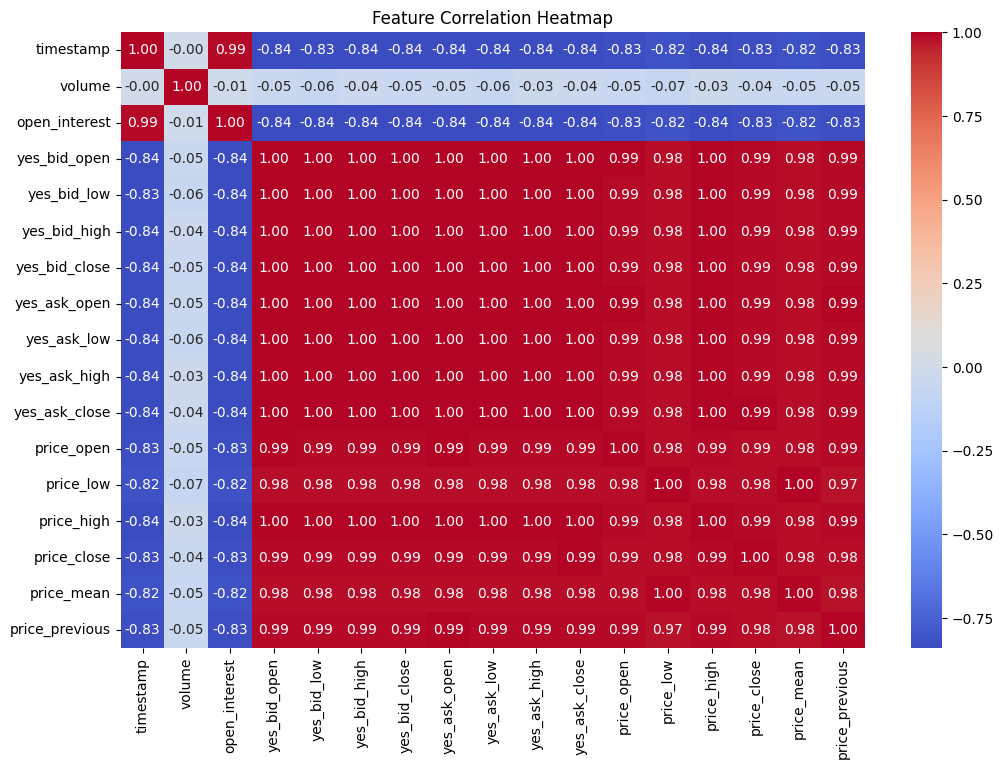

Conclusion: The most important observation from the heatmap is the strong positive correlation between price-related metrics (e.g., price_open, price_close, price_mean, and price_previous) as the coefficients are all above 0.98. 
This shows market prices moved consistently across, and there was a stable and unified market sentiment in the days leading up to election day.
Additionally, the negative correlation between timestamp and the mean price (-0.82) suggests that Trump's odds decreased steadily as the election approached.
Later on we will compare this with online sentiment on Reddit/twitter to see how closely public opinion aligns with prediction market movements.


In [ ]:
# Heatmap for how correlated certain metrics are
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.show()
print("Conclusion: The most important observation from the heatmap is the strong positive correlation between price-related metrics (e.g., price_open, price_close, price_mean, and price_previous) as the coefficients are all above 0.98. \nThis shows market prices moved consistently across, and there was a stable and unified market sentiment in the days leading up to election day.")
print("Additionally, the negative correlation between timestamp and the mean price (-0.82) suggests that Trump's odds decreased steadily as the election approached.")
print("Later on we will compare this with online sentiment on Reddit/twitter to see how closely public opinion aligns with prediction market movements.")


A boxplot of trade volume showed that most trading activity was concentrated at relatively low levels, with the interquartile range capturing modest volumes. However, the presence of extreme outliers—some exceeding 500,000 contracts—points to sudden, high-impact events triggering bursts of activity. These spikes likely correspond to major political developments such as debates, court rulings, or campaign milestones.

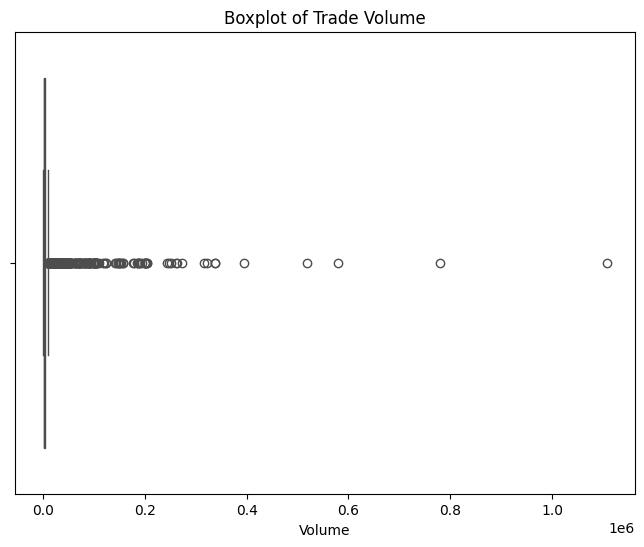

Conclusion: The boxplot of trade volume shows the majority of trading activity is concentrated at lower volumes but with a few significant outliers extending beyond 500,000.
The outliers represent rare spikes in trading and are likely caused by major announcements leading up to the 2024 presidential election, or by 'whale' investors who place extremely large bets.


In [ ]:
# Boxplot to find outliers
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['volume'], color='orange')
plt.title('Boxplot of Trade Volume')
plt.xlabel('Volume')
plt.show()

print("Conclusion: The boxplot of trade volume shows the majority of trading activity is concentrated at lower volumes but with a few significant outliers extending beyond 500,000.")
print("The outliers represent rare spikes in trading and are likely caused by major announcements leading up to the 2024 presidential election, or by 'whale' investors who place extremely large bets.")

A timeline plot of volume over time further contextualized these outliers, highlighting key periods where trading surged. These spikes align with moments when new information entered the public sphere, suggesting that Kalshi's market rapidly responds to emerging events.

To assess whether these high-volume periods impacted price behavior, we conducted a two-sample t-test comparing Trump's contract closing prices during high-volume and low-volume trading intervals. The results indicated a statistically significant difference (p < 0.05), with Trump’s contract price being lower during high-volume periods. This supports the hypothesis that bursts of trading—likely driven by breaking news or public disclosures—correlated with declining market sentiment for Trump, possibly reflecting unfavorable information.

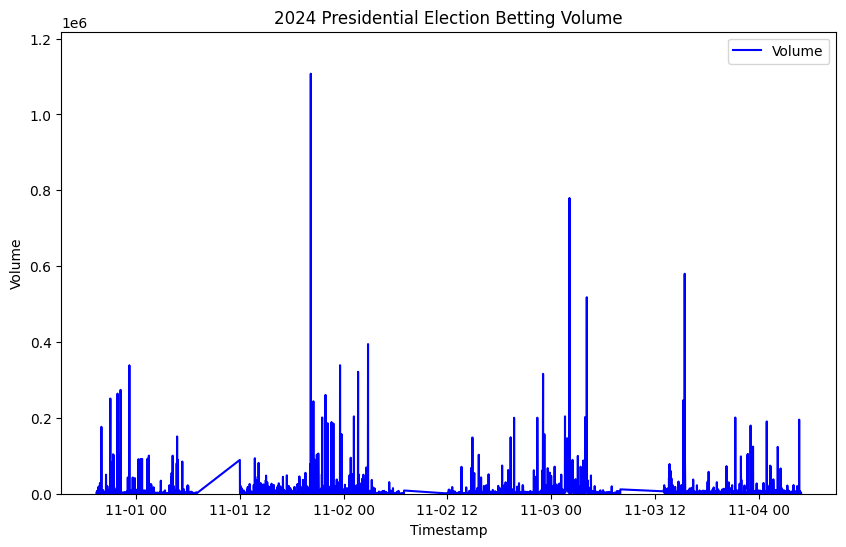


Hypothesis Testing:
Trump's Low Volume Mean: 55.2495789828225
Trump's High Volume Mean: 54.3
Low Volume Count: 2969
High Volume Count: 990
T-statistic: 9.986891684489871
P-value: 3.267782203915348e-23

Conclusion: During the low-volume trading periods leading up to the presidential election, Trump's closing price, on average, was statistically significantly greater than during high-volume trading periods.
 Since trading volume typically increases when new information or news is released, it is likely that the information leading up to the election decreased bettors' confidence in the likelihood of Trump winning.


In [ ]:
# Volume histogram for days before the election
plt.figure(figsize=(10, 6))
plt.plot(df['timestamp'], df['volume'], label='Volume', color='blue')
plt.ylim(0, df['volume'].max() *1.1)
plt.title('2024 Presidential Election Betting Volume')
plt.xlabel('Timestamp')
plt.ylabel('Volume')
plt.legend()
plt.show()

# Hypothesis testing for impact of Volume on Trump's Price Close
Q3 = df['volume'].quantile(0.75)
low_volume = df[df['volume'] <= Q3]['price_close']
high_volume = df[df['volume'] > Q3]['price_close']

t_stat, p_value = ttest_ind(low_volume, high_volume)
low_volume_mean = low_volume.mean()
high_volume_mean = high_volume.mean()
low_volume_count = low_volume.shape[0]
high_volume_count = high_volume.shape[0]

print("\nHypothesis Testing:")
print(f"Trump's Low Volume Mean: {low_volume_mean}")
print(f"Trump's High Volume Mean: {high_volume_mean}")
print(f"Low Volume Count: {low_volume_count}")
print(f"High Volume Count: {high_volume_count}")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

print("\nConclusion: During the low-volume trading periods leading up to the presidential election, Trump's closing price, on average, was statistically significantly greater than during high-volume trading periods.\n Since trading volume typically increases when new information or news is released, it is likely that the information leading up to the election decreased bettors' confidence in the likelihood of Trump winning.")

Together, these findings offer evidence that Kalshi’s market not only reflects collective beliefs but also dynamically responds to informational shocks, making it a rich subject for further sentiment-driven analysis.

# Primary Analysis






We used linear regression to find whether there’s a linear relationship between social media sentiment and the market’s predicted probability of a Trump election win on Kalshi. We initially decided to use posts and comments in the r/Politics reddit channel for our social media sentiment:

In [ ]:
!pip install praw
import praw
import pandas as pd
import datetime

reddit = praw.Reddit(
    client_id='redacted',
    client_secret='redacted',
    user_agent='redacted'
)
# Define subreddit and date range
subreddit_name = "politics"
start_date = datetime.datetime(2025, 5, 1).timestamp()
end_date = datetime.datetime(2025, 5, 7).timestamp()

# Initialize data storage
posts_dict = {
    "Title": [], "Post Text": [], "ID": [], "Score": [],
    "Total Comments": [], "Created On": [], "Post URL": []
}

# Fetch posts (max 1,000 due to API limit)
subreddit = reddit.subreddit(subreddit_name)
posts = subreddit.new(limit=1000)

# Filter posts by date
for post in posts:
    if start_date <= post.created_utc <= end_date:
        posts_dict["Title"].append(post.title)
        posts_dict["Post Text"].append(post.selftext)
        posts_dict["ID"].append(post.id)
        posts_dict["Score"].append(post.score)
        posts_dict["Total Comments"].append(post.num_comments)
        posts_dict["Created On"].append(post.created_utc)
        posts_dict["Post URL"].append(post.url)

# Convert to DataFrame
all_posts = pd.DataFrame(posts_dict)
all_posts['Created On'] = pd.to_datetime(all_posts['Created On'], unit='s')

# Save or analyze
all_posts.to_csv("reddit_posts.csv", index=False)
print(f"Retrieved {len(all_posts)} posts from r/{subreddit_name}")

However, we quickly ran into trouble: Reddit had made some changes to their API in 2023, making it impossible to scrape content from a particular time frame, in our case, the week surrounding the election. We were only able to scrape the 1000 most recent posts from the subreddit.

With all the troubles the Reddit API was giving us, we decided to use vader to produce sentiment scores from a Kaggle dataset with election related tweets on X posted in the same timeframe as our Kalshi data. Since both market probability and sentiment scores are continuous, linear regression makes the most sense as a solid starting point because it provides a simple and easy to interpret method for estimating how sentiment might influence market probabilities. Additionally, it gives outputs like the slope, intercept, and R-squared to quantify the strength and direction of the relationship.

vaderSentiment github: https://github.com/cjhutto/vaderSentiment

Kaggle dataset: https://www.kaggle.com/datasets/emirhanai/2024-u-s-election-sentiment-on-x/data?select=val.csv


In [ ]:
# VADER Sentiment used
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Formatting kalshi_df
kalshi_df = df.set_index('timestamp')

# Trying to make hourly
hourly_kalshi = kalshi_df['price_close'].resample('h').mean().reset_index()
hourly_kalshi.columns = ['timestamp', 'hourly_probability']

# Drop rows with NaN values in 'hourly_probability'
hourly_kalshi = hourly_kalshi.dropna(subset=['hourly_probability'])

# Importing kaggle dataset
kaggle_df = pd.read_csv('train.csv')

# Initialize VADER analyzer
analyzer = SentimentIntensityAnalyzer()

# Calculate VADER compound scores instead of categorical mapping
kaggle_df['text_content'] = kaggle_df['tweet_text']
kaggle_df['vader_score'] = kaggle_df['text_content'].apply(
    lambda text: analyzer.polarity_scores(str(text))['compound']
)

# Only keep Trump and Democratic Party rows
#kaggle_df['sentiment_numeric'] = kaggle_df['sentiment'].map(sentiment_map)
kaggle_df['timestamp'] = pd.to_datetime(kaggle_df['timestamp'])

# For Democratic Party, invert sentiment (same logic but with continuous scores)
kaggle_df['sentiment_for_trump'] = kaggle_df.apply(
    lambda row: -row['vader_score'] if row['party'] == 'Democratic Party' else row['vader_score'],
    axis=1
)

# Only keep Republican and Democratic Party
kaggle_df = kaggle_df[kaggle_df['party'].isin(['Republican Party', 'Democratic Party'])].copy()

# Convert and sort timestamps
kaggle_df['timestamp'] = pd.to_datetime(kaggle_df['timestamp'])
kaggle_df = kaggle_df.sort_values('timestamp').reset_index(drop=True)

In [ ]:
# Create copy for tracking used indices
kaggle_temp = kaggle_df.copy()
used_indices = set()
closest_sentiments = []
print(hourly_kalshi.columns)

for kalshi_ts in hourly_kalshi['timestamp']:
    # Calculate time differences with unused entries
    time_diffs = (kaggle_temp['timestamp'] - kalshi_ts).abs()
    time_diffs.index = kaggle_temp.index  # Preserve original indices

    # Find closest unused entry
    if not time_diffs.empty:
        closest_idx = time_diffs.idxmin()
        closest_sentiments.append(kaggle_temp.loc[closest_idx, 'sentiment_for_trump'])
        used_indices.add(closest_idx)
        # Remove used entry from consideration
        kaggle_temp = kaggle_temp.drop(index=closest_idx)

# Add aligned data to Kalshi DataFrame
hourly_kalshi['sentiment'] = closest_sentiments


Index(['timestamp', 'hourly_probability'], dtype='object')


In [ ]:
# Model Setup
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Doing Linear Regression
X = hourly_kalshi[['sentiment']]
y = hourly_kalshi['hourly_probability']

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Calculate metrics
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)
equation = f'y = {model.coef_[0]:.2f}x + {model.intercept_:.2f}'

# Visualization



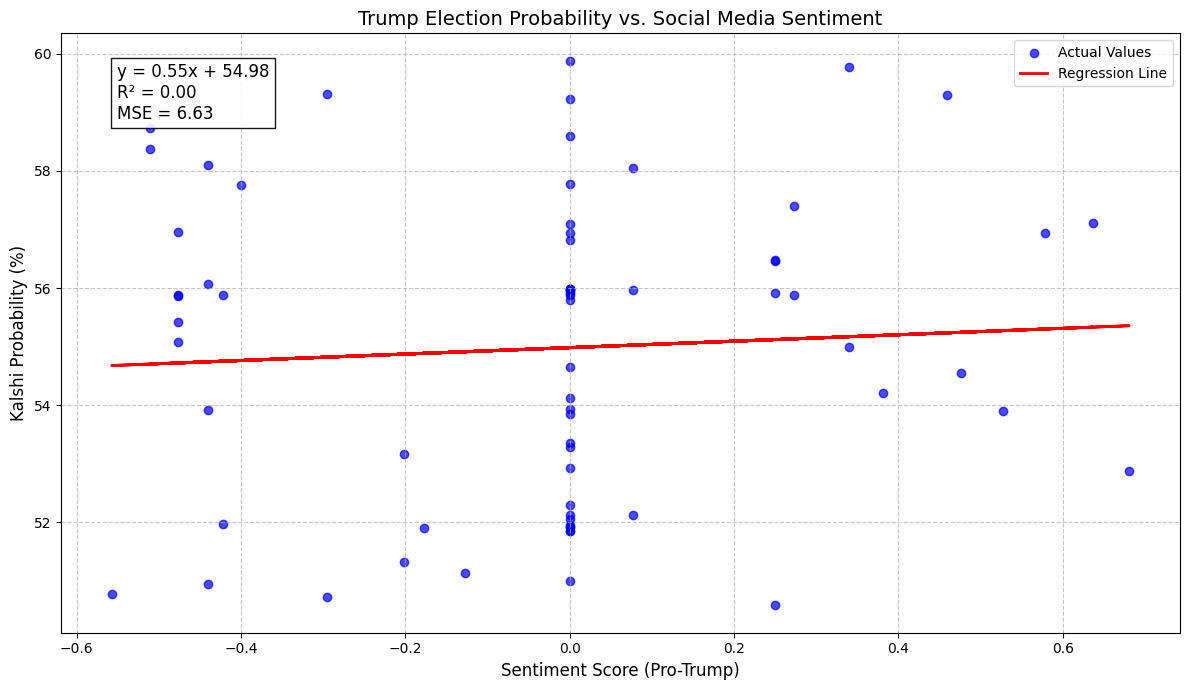

Aligned Data Preview:
            timestamp  hourly_probability  sentiment
0 2024-10-31 19:00:00           57.757576    -0.4003
1 2024-10-31 20:00:00           57.116667     0.6369
2 2024-10-31 21:00:00           58.366667    -0.5106
3 2024-10-31 22:00:00           59.300000     0.4588
4 2024-10-31 23:00:00           59.233333    -0.0000

Model Summary:
Regression Equation: y = 0.55x + 54.98
R-squared: 0.00
Mean Squared Error: 6.63


In [ ]:

# Visualization
plt.figure(figsize=(12, 7))
plt.scatter(X, y, color='blue', alpha=0.7, label='Actual Values')
plt.plot(X, y_pred, color='red', linewidth=2, label='Regression Line')

# Annotation settings
plt.title('Trump Election Probability vs. Social Media Sentiment', fontsize=14)
plt.xlabel('Sentiment Score (Pro-Trump)', fontsize=12)
plt.ylabel('Kalshi Probability (%)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Add regression equation and metrics
text_str = f'{equation}\nR² = {r2:.2f}\nMSE = {mse:.2f}'
plt.text(0.05, 0.95, text_str, transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top',
         bbox=dict(facecolor='white', alpha=0.9))

plt.legend()
plt.tight_layout()
plt.show()


# Print results
print("Aligned Data Preview:")
print(hourly_kalshi[['timestamp', 'hourly_probability', 'sentiment']].head())
print("\nModel Summary:")
print(f"Regression Equation: {equation}")
print(f"R-squared: {r2:.2f}")
print(f"Mean Squared Error: {mse:.2f}")

The regression equation from the analysis was y = 0.55x + 54.98, which means that for every unit increase in sentiment, the predicted market probability increases by 0.55 percentage points. However, since the sentiment scores in the dataset only ranged from about -0.5 to +0.6, the total effect of sentiment on probability is very small. For example, going from the lowest to the highest sentiment only predicts about a 0.6 percent increase in probability.

The model’s R-squared value was 0.00, which shows that sentiment explains none of the variance in Kalshi’s market probability. This result is likely due to the market probability being too similar throughout the timeframe we analyzed. It stayed almost the same no matter what the sentiment was, so the regression line could not find a meaningful pattern.

The mean squared error was 6.63, which tells us the average difference between the actual probabilities and the predictions from the regression line. The plot illustrates that probability values were spread out similarly across all sentiment levels, and the regression line is nearly flat because there was no clear trend for it to fit.

These results suggest that market probabilities were very stable over the timeframe we analyzed, and social media sentiment had no measurable effect on market expectations during this period.

Because the market probability barely changed during this period, it is hard to detect any relationship, and the small slope from the regression is probably just due to random variation.

To better understand any potential connection, future work might need to use a longer timeframe, include more variables, or try different analysis methods. Overall, sentiment alone does not explain the market’s probability movements in this case.

# Conclusion

After reading the project, an uninformed reader would understand the overall goal of testing whether social media sentiment predicts Kalshi’s market probability for a Trump election, but might still lack context. The project explains the analysis and results clearly, but could benefit from better understanding the nature of Kalshi markets, how sentiment scores are actually calculated generated, and why sentiment might affect market probabilities. Without this, a reader unfamiliar with these topics might not fully grasp the motivation or relevance.

Otherwise, the project provides a clear analysis. The regression shows an R-squared of zero, and  reading the analysis of these results would inform a reader that, in the short term, there is no evident relationship between twitter sentiment and market odds. This is may be useful for people who are trying to predict odds themselves or were considering making a bet based on what they have been seeing on social media. This tutorial indicates this would not be a good idea. Expanding the analysis to get further into why no relationship was found and what could be explored next might make the project more informative for readers.